## Predicting Snow-to-Liquid Ratios using a Random Forest Model

#### *ATMS 523 Module 8: Kaitlyn Jesmonth*

***

There are many inherent challenges in forecasting snowfall. Forecasters will commonly assess the quantative precipitation forecast (QPF) first before converting the forecasted amount of liquid to snow. Even with a perfect QPF, large errors in snowfall prediction can occur. One key factor in this problem is the conversion ratio of melted liquid equivalent to new snowfall depth, or the the snow-to-liquid ratio (SLR). This ratio can be dynamic, though often treated as constant in numerical weather prediction (NWP).

Commonly the 10:1 ratio, that is 10 inches of snow for every 1 inch of liquid, has been widely accepted as standard from a climatology in the mid-nineteenth century (Judson and Doesken 2000). Yet, numerous factors, some of which have to be parameterized in NWP, can affect the SLR:

- ice crystal shape and size
- air temperature and degree of supersaturation in the ice growth region
- sublimation and melting once the ice crystal falls out of the cloud
- prevailing surface weather conditions

(Roebber et al. 2003). Past research to improve the prediction of SLR has been conducted to the higher terrain in the western CONUS (Alcott and Steenburgh 2009). This project aims to use a machine learning approach in the Northeast U.S. to predict the SLR in Albany, NY.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

### Part 1: Accessing the Data

The [NCEI Global Historical Climatology Network - Hourly (GHCNh)](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly) dataset will be used to access hourly automated surface observing system (ASOS) data from the Albany International Airport (KALB) in New York.

In [3]:
url = 'https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-station/GHCNh_USW00014735_por.psv'
response = requests.get(url)
if response.status_code == 200:
    # Open a file in write-binary mode
    with open('GHCNh_USW00014735_por.psv', 'wb') as file:
        # Write the content of the response to the file
        file.write(response.content)
        print('Download Successful!')
else:
    print(f'Failed to retrieve content: {response.status_code}')

Download Successful!


In [2]:
df = pd.read_table('GHCNh_USW00014735_por.psv', delimiter='|', dtype=str)
df

,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Quality_Code,precipitation_24_hour_Report_Type,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID
0,USW00014735,ALBANY INTL AP,1929,01,01,07,00,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014735,ALBANY INTL AP,1929,01,01,10,00,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014735,ALBANY INTL AP,1929,01,01,13,00,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014735,ALBANY INTL AP,1929,01,01,16,00,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014735,ALBANY INTL AP,1929,01,01,19,00,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951168,USW00014735,ALBANY INTL AP,2024,04,15,23,51,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,MET11804/15/24 18:51:02 METAR KALB 152351Z 270...,NaN,F,NaN,343,725180-14735
951169,USW00014735,ALBANY INTL AP,2024,04,16,00,51,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,MET09704/15/24 19:51:03 METAR KALB 160051Z 000...,NaN,F,NaN,343,725180-14735
951170,USW00014735,ALBANY INTL AP,2024,04,16,01,51,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,MET09604/15/24 20:51:03 METAR KALB 160151Z 000...,NaN,F,NaN,343,725180-14735
951171,USW00014735,ALBANY INTL AP,2024,04,16,02,51,42.7472,-73.7992,85.3,...,NaN,NaN,NaN,NaN,MET10204/15/24 21:51:03 METAR KALB 160251Z 000...,NaN,F,NaN,343,725180-14735


### Part 2: Dataset Analysis

#### Construct time index

In [3]:
# construct a datetime column to use as a coordinate
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# set the index to time
df.set_index('time', inplace=True)

#### Select variables of interest

In order to reduce the size of the dataset so it contains the necessary information, only weather variable columns should be selected. For the present weather conditions reported, the [GHCNh documentation](https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf) describes several different column types: 
- `pres_wx_MW` sourced from manual reports
- `pres_wx_AW` sourced from automated sensors
- `pres_wx_AU` sourced from automated ASOS/AWOS sensors

Since the KALB station is an ASOS station and since the present weather from manual reports gives descriptions more in depth than needed for this analysis, only the present weather AU columns will be selected. Lastly, wind gust information was left out of this analysis due to the lack of data.

In [4]:
# select relevant columns to this analysis
variable_names = ['temperature', 'dew_point_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'relative_humidity',
                  'wet_bulb_temperature', 'visibility', 'precipitation_6_hour', 'snow_depth', 'pres_wx_AU1', 'pres_wx_AU2', 'pres_wx_AU3']
df_selected = df[variable_names]
df_selected

,temperature,dew_point_temperature,sea_level_pressure,wind_direction,wind_speed,relative_humidity,wet_bulb_temperature,visibility,precipitation_6_hour,snow_depth,pres_wx_AU1,pres_wx_AU2,pres_wx_AU3
time,,,,,,,,,,,,,
1929-01-01 07:00:00,0.6,NaN,1024.0,180,1.4,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
1929-01-01 10:00:00,-1.1,NaN,1025.1,270,0.5,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
1929-01-01 13:00:00,-1.7,NaN,1025.4,090,0.9,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN
1929-01-01 16:00:00,2.8,NaN,1025.1,180,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929-01-01 19:00:00,3.3,NaN,1021.3,180,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15 23:51:00,12.8,-1.1,1014.5,270,3.1,38,6.7,16.093,NaN,NaN,NaN,NaN,NaN
2024-04-16 00:51:00,11.1,-0.6,1015.4,999,0.0,45,6.0,16.093,NaN,NaN,NaN,NaN,NaN
2024-04-16 01:51:00,8.3,0.0,1016.0,999,0.0,56,4.8,16.093,NaN,NaN,NaN,NaN,NaN


#### One-hot encode the present weather variable

In [5]:
# one-hot encode the present weather columns
df_encoded = pd.get_dummies(df_selected, columns=['pres_wx_AU1', 'pres_wx_AU2', 'pres_wx_AU3'], prefix='wx')

#### Reduce the number of present weather encoded columns

Several weather conditions may be reported at the same time and can appear in any of the three `pres_wx_AU` columns. When one-hot encoding each present weather column, several duplicate wx conditions were created as new column headers. This results from a given weather condition being present in multiple present weather columns. Thus, all columns with duplicate weather conditions will be synthesized. This will ensure unique column headers for the final dataset.

In [6]:
# grab columns for present wx
selected_columns = pd.Series(df_encoded.columns).str.startswith('wx_')
columns_filtered = df_encoded.columns[selected_columns]

In [7]:
# create regex expressions to find unique present weather identifiers
pattern1 = r'_([+-]\w+):'       # intensity descriptor in between _ and :
pattern2 = r'_(\w+):'           # values between _ and :
pattern3 = r'_(\w+)'            # values after just an _
pattern4 = r'_([+-]\w+)'        # intensity descriptor after just an _

# initialize list to store matched wx conditions
matched = []
# intialize list in case a wx condition doesn't match regex
not_matched=[]

for column in columns_filtered.values:
    matches1 = re.findall(pattern1, column)
    matches2 = re.findall(pattern2, column)
    matches3 = re.findall(pattern3, column)
    matches4 = re.findall(pattern4, column)
    if matches1:
        # gather present wx conditions with intensity descriptors
        matched.append(matches1[0])
        #print(matches1[0])
    elif matches2:
        # gather present wx conditions
        matched.append(matches2[0])
        #print(matches2[0])
    elif matches3:
        # gather present wx conditions
        matched.append(matches3[0])
        #print(matches3[0])
    elif matches4:
        # gather present wx conditions with intensity descriptors
        matched.append(matches4[0])
        #print(matches4[0])
    else:
        print('Warning: present weather condition may be left out!\n'
              'Check the not_matched list for which variable(s) may be excluded. Change regex if necessary.)')
        not_matched.append(column)

In [18]:
# initialize new df with all other columns besides present wx
new_df = df_encoded.iloc[:,:10]

# initialize counter variable
counter = 0

# loop through present wx columns
for wx_cond in matched:
    # check if present wx cond in final df already
    if wx_cond in new_df.columns:
        # if in df already, merge columns
        new_df[wx_cond] = df_encoded.iloc[:, 10+counter] | new_df[wx_cond]
        #print(f'duplicate: {wx_cond}')
    else:
        # if not, add to the new df
        new_df[wx_cond] = df_encoded.iloc[:, 10+counter]

    # increase counter by 1
    counter += 1

new_df

,temperature,dew_point_temperature,sea_level_pressure,wind_direction,wind_speed,relative_humidity,wet_bulb_temperature,visibility,precipitation_6_hour,snow_depth,...,SQ,TS,UP,VCFG,VCTS,BL,BLDU,GR,MI,SG
time,,,,,,,,,,,,,,,,,,,,,
1929-01-01 07:00:00,0.6,NaN,1024.0,180,1.4,NaN,NaN,8.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1929-01-01 10:00:00,-1.1,NaN,1025.1,270,0.5,NaN,NaN,8.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1929-01-01 13:00:00,-1.7,NaN,1025.4,090,0.9,NaN,NaN,0.8,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1929-01-01 16:00:00,2.8,NaN,1025.1,180,7.7,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1929-01-01 19:00:00,3.3,NaN,1021.3,180,5.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15 23:51:00,12.8,-1.1,1014.5,270,3.1,38,6.7,16.093,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2024-04-16 00:51:00,11.1,-0.6,1015.4,999,0.0,45,6.0,16.093,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2024-04-16 01:51:00,8.3,0.0,1016.0,999,0.0,56,4.8,16.093,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


#### Only select times when have 6-hour precipitation and snow depth data

In [19]:
df_cleaned = new_df.dropna(subset=['precipitation_6_hour', 'snow_depth'])

#### Convert weather variables to floats

In [20]:
for var_name in variable_names[:10]:
    df_cleaned[var_name] = df_cleaned[var_name].astype(float)

#### Only keep data at 6-hour increments (based on snow depth measurements being measured every 6 hours)

In [21]:
def six_hours_later(current_time, previous_time):
    return (current_time - previous_time) == pd.Timedelta(hours=6)

# initialize list for rows to keep
rows_to_keep = []

# initialize the previous time
previous_time = df_cleaned.index[0]

# loop through the entire dataset by row
for i in range(1, len(df_cleaned.index)):
    current_time = df_cleaned.index[i]
    # check current time is 6 hours after the previous time
    if six_hours_later(current_time, previous_time):
        # keep both the previous time and current times
        rows_to_keep.append(i-1)
        rows_to_keep.append(i)
    previous_time = current_time

In [22]:
new_df = df_cleaned.iloc[rows_to_keep]

In [23]:
new_df

,temperature,dew_point_temperature,sea_level_pressure,wind_direction,wind_speed,relative_humidity,wet_bulb_temperature,visibility,precipitation_6_hour,snow_depth,...,SQ,TS,UP,VCFG,VCTS,BL,BLDU,GR,MI,SG
time,,,,,,,,,,,,,,,,,,,,,
1973-01-31 06:00:00,-6.0,-8.0,1017.8,290.0,7.2,86.0,-6.6,NaN,0.0,200.0,...,False,False,False,False,False,False,False,False,False,False
1973-01-31 12:00:00,-17.7,-24.4,1030.1,300.0,6.6,56.0,-18.6,NaN,0.0,200.0,...,False,False,False,False,False,False,False,False,False,False
1973-12-18 00:00:00,-11.1,-12.7,999.2,360.0,3.6,88.0,-11.5,NaN,4.0,200.0,...,False,False,False,False,False,False,False,False,False,False
1973-12-18 06:00:00,-12.7,-16.1,1003.5,280.0,8.2,76.0,-13.5,NaN,1.0,280.0,...,False,False,False,False,False,False,False,False,False,False
1974-01-10 18:00:00,-10.0,-11.6,1024.4,10.0,2.5,88.0,-10.4,NaN,5.0,200.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-11 17:51:00,1.7,0.0,1012.1,340.0,2.6,89.0,1.0,0.402,0.2,30.0,...,False,False,False,False,False,False,False,False,False,False
2021-02-19 05:51:00,-6.7,-7.8,1026.9,360.0,1.5,92.0,-7.0,3.219,0.0,150.0,...,False,False,False,False,False,False,False,False,False,False
2021-02-19 11:51:00,-7.2,-7.8,1024.2,999.0,0.0,96.0,-7.4,3.219,1.5,180.0,...,False,False,False,False,False,False,False,False,False,False


#### Calculate snow-to-liquid ratio

To calculate SLR at an increment of six hours, the calculation for change in new precipitation fallen and snow depth is required.

In [24]:
# convert snow depth and precip to inches
new_df['snow_depth'] = new_df['snow_depth'] * 0.03937007874                       # cm (to nearest tenth) to inch
new_df['precipitation_6_hour'] = new_df['precipitation_6_hour'] * 0.03937007874   # mm to inch

In [25]:
# initalize list with slr data
slr_values = []

# intialize list of rows to keep
rows_to_keep = []

# store precipitation and snow depth data in variables for simplicity
precip = new_df['precipitation_6_hour']
snow = new_df['snow_depth']

# loop through the entire dataset by every other row
for i in range(1, len(new_df.index), 2):
    previous_time_idx = i - 1
    current_time_idx = i
    current_time = new_df.index[i]
    # get change in accumulated precipitation and snow depth
    current_precip = precip.iloc[current_time_idx]
    current_snow = snow.iloc[current_time_idx]
    past_snow = snow.iloc[previous_time_idx]
    #print(current_precip, current_snow, past_snow)
    if ((current_precip > 0.) and (current_snow > past_snow)):
        # since it is a 6-hour precip measurement we don't need to do anything here
        delta_precip = current_precip
        # calculate change in snow depth
        delta_snow = current_snow - past_snow
        # calculate slr
        slr = delta_snow / delta_precip
        # store in slr list
        slr_values.append(slr)
        # only keep row for current time
        rows_to_keep.append(i)
        print(delta_precip, delta_snow)
    #else:
        #print('no calculation made')
    

# only keep data at the end of the six-hour measurement
final_df = new_df.iloc[rows_to_keep]

0.03937007874 3.1496062991999993
0.23622047244 9.0551181102
0.11811023622 1.9685039370000004
0.07874015748 1.9685039370000004
0.03937007874 1.181102362199999
0.11811023622 1.9685039370000004
0.03937007874 1.1811023621999999
0.11811023622 1.181102362199999
0.11811023622 3.1496062992000002
0.03937007874 1.1811023621999999
0.03937007874 0.7874015748000005
0.07874015748 1.1811023622
0.01968503937 1.1811023622
0.07874015748 0.7874015748000005
0.23622047244 1.9685039369999995
0.35433070866 3.9370078740000007
0.11811023622 1.9685039369999977
0.07874015748 1.9685039370000013
0.03937007874 0.7874015748000005
0.01968503937 0.39370078740000025
0.15748031496 1.9685039369999995
0.011811023622 0.7874015747999996
0.07874015748 1.1811023622
0.11811023622 1.9685039370000004
0.03937007874 1.181102362199999
0.07874015748 1.968503937
0.03937007874 0.7874015748000001
0.11811023622 1.9685039369999995
0.07874015748 0.7874015748000005
0.03937007874 1.1811023622000008
0.03937007874 1.181102362199999
0.11811023

#### Merge snow-to-liquid ratio data back to final dataset

In [26]:
final_df['snow_to_liquid_ratio'] = slr_values

#### Check to make sure present weather conditions have values that are true

In [27]:
# make list of all variable names
variable_names = list(final_df.columns)
last_variable = len(variable_names) - 1

# loop through all present wx condition variables
for var_name in variable_names[11:last_variable]:
    # check unique values
    unique_values = np.unique(final_df[var_name])
    # ensure columns with only 0's get dropped
    if (len(unique_values) < 2 and unique_values[0]==0.0):
        final_df = final_df.drop(var_name, axis=1)

final_df

,temperature,dew_point_temperature,sea_level_pressure,wind_direction,wind_speed,relative_humidity,wet_bulb_temperature,visibility,precipitation_6_hour,snow_depth,+PL,-SN,BR,snow_to_liquid_ratio
time,,,,,,,,,,,,,,
1973-12-18 06:00:00,-12.7,-16.1,1003.5,280.0,8.2,76.0,-13.5,NaN,0.039370,11.023622,False,False,False,80.000000
1974-01-11 12:00:00,-9.4,-10.5,1014.1,30.0,7.7,92.0,-9.7,NaN,0.236220,9.842520,False,False,False,38.333333
1974-04-10 00:00:00,-2.1,-4.3,1009.6,350.0,5.1,85.0,-3.0,NaN,0.118110,9.842520,False,False,False,16.666667
1975-02-10 00:00:00,-13.9,-14.4,1020.7,999.0,0.0,96.0,-14.0,16.093,0.078740,9.842520,False,False,False,25.000000
1975-02-13 00:00:00,-16.7,-17.2,1011.2,999.0,0.0,96.0,-16.8,14.484,0.039370,11.023622,False,False,False,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25 11:51:00,-2.8,-5.0,1005.4,30.0,2.1,85.0,-3.5,1.207,0.279528,5.118110,False,True,True,14.084507
2018-02-18 11:51:00,-0.6,-5.0,1020.6,310.0,2.6,72.0,-2.1,16.093,0.047244,1.968504,False,False,False,16.666667
2018-03-13 11:51:00,0.0,-2.2,1006.7,350.0,4.6,85.0,-0.8,1.609,0.106299,7.086614,False,True,True,18.518519


#### Quality Control Snow-to-Liquid Ratios

Oftentimes with an ASOS station in light snow in particular, there can be significant undercatch of the snow in the gauge. When the snow is melted to liquid and recorded as precipitation, the values are very low. This results in some very high SLRs. Here, we will remove any SLRs over 40:1 to combat this problem.

In [48]:
for index, row in final_df.iterrows():
    if row['snow_to_liquid_ratio'] > 40.:
        final_df.drop(index, inplace=True)

On the otherhand, there can be significant compaction of the snow within 6 hours. This can lead to little change in snow depth while precipitation primarily changes. This results in SLRs that are way too low. Here, we will remove any SLRs under 2:1 to combat this problem.

In [51]:
for index, row in final_df.iterrows():
    if row['snow_to_liquid_ratio'] < 2.:
        final_df.drop(index, inplace=True)

In [52]:
final_df

,temperature,dew_point_temperature,sea_level_pressure,wind_direction,wind_speed,relative_humidity,wet_bulb_temperature,visibility,precipitation_6_hour,snow_depth,+PL,-SN,BR,snow_to_liquid_ratio
time,,,,,,,,,,,,,,
1974-01-11 12:00:00,-9.4,-10.5,1014.1,30.0,7.7,92.0,-9.7,NaN,0.236220,9.842520,False,False,False,38.333333
1974-04-10 00:00:00,-2.1,-4.3,1009.6,350.0,5.1,85.0,-3.0,NaN,0.118110,9.842520,False,False,False,16.666667
1975-02-10 00:00:00,-13.9,-14.4,1020.7,999.0,0.0,96.0,-14.0,16.093,0.078740,9.842520,False,False,False,25.000000
1975-02-13 00:00:00,-16.7,-17.2,1011.2,999.0,0.0,96.0,-16.8,14.484,0.039370,11.023622,False,False,False,30.000000
1975-12-22 18:00:00,-7.8,-10.0,1010.3,360.0,4.6,84.0,-8.4,1.609,0.118110,9.842520,False,False,False,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25 11:51:00,-2.8,-5.0,1005.4,30.0,2.1,85.0,-3.5,1.207,0.279528,5.118110,False,True,True,14.084507
2018-02-18 11:51:00,-0.6,-5.0,1020.6,310.0,2.6,72.0,-2.1,16.093,0.047244,1.968504,False,False,False,16.666667
2018-03-13 11:51:00,0.0,-2.2,1006.7,350.0,4.6,85.0,-0.8,1.609,0.106299,7.086614,False,True,True,18.518519


### Part 3: Random Forest Model

In [54]:
# subset features (usually represented by X) and target data (usually represented by y) from dataset
X = final_df.drop('snow_to_liquid_ratio', axis=1)
y = final_df['snow_to_liquid_ratio']

In [62]:
# separate training and testing data with a 80/20 split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, train_size=0.7)

In [63]:
# set parameters and grid search with a random forest regressor
param_grid = {'bootstrap': [True, False],  
              'max_depth': [10, 50, None],  
              'max_features': ['auto', 'sqrt'],  
              'min_samples_leaf': [1, 4],  
              'min_samples_split': [2, 5],  
              'n_estimators': [200, 1000]}

grid = GridSearchCV(RandomForestRegressor(), param_grid)

In [64]:
# fit random forest regressor
grid.fit(Xtrain, ytrain)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 1000]})

In [65]:
# find best parameters
grid.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [66]:
# find best random forest regressor model
best_model = grid.best_estimator_

# train best random forest regressor model
best_model.fit(Xtrain, ytrain)

# validate best random forest regressor model using the test data
ybest = best_model.predict(Xtest)

In [67]:
# get r2 and rmse values for best random forest regressor model 
r2_best = r2_score(ytest, ybest)
rmse_best = np.sqrt(mean_squared_error(ytest, ybest))

print(f'R-Squared: {r2_best}')
print(f'Root Mean Square Error: {rmse_best}')

R-Squared: 0.4651989470184935
Root Mean Square Error: 6.017052174705251


As we can see by our R-Squared value and RMSE, our model doesn't perform too well here. This is likely a factor of several reasons, including lack of data to feed into the random forest and the inherent error in using 6-hour snow depth in making a snow-to-liquid ratio calculation. We will explore some of these reasons below.

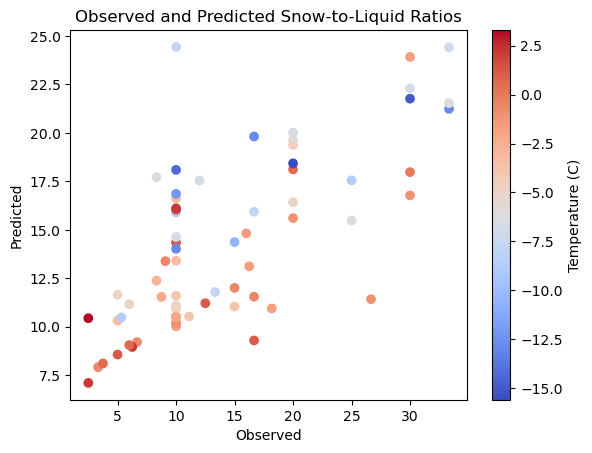

In [81]:
# create a scatter plot of the predicted and observed slr
plt.scatter(ytest, ybest, c=Xtest['temperature'], cmap='coolwarm', marker='o')

# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed and Predicted Snow-to-Liquid Ratios')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Temperature (C)')

# Display the plot
plt.show()

Higher temperatures are primarily found in the bottom left of this plot. It is possible the snow was melting slightly and compacting in between snow depth measurements leading to a lower SLR than expected. Also, lower SLRs would be expected in a warmer environment due to the snow partially melting as it falls. Our model seems to overshoot SLRs values with higher temperatures.

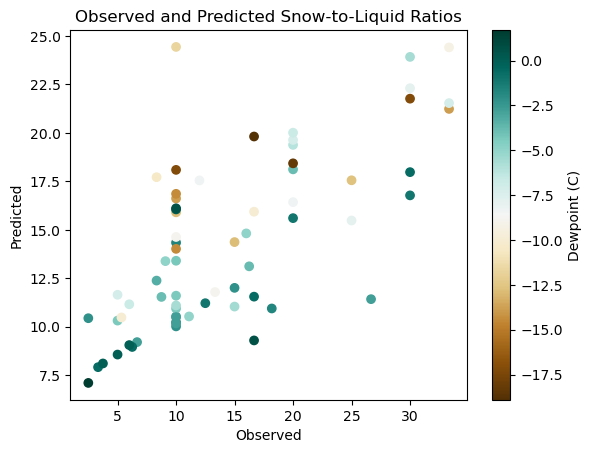

In [80]:
# create a scatter plot of the predicted and observed slr
plt.scatter(ytest, ybest, c=Xtest['dew_point_temperature'], cmap='BrBG', marker='o')

# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed and Predicted Snow-to-Liquid Ratios')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Dewpoint (C)')

# Display the plot
plt.show()

Similar to temperature, the higher dewpoints are primarily found in the bottom left of this plot. Lower SLRs would be expected in a more moist environment where if saturated, the temperature is also likely warmer. Higher SLRs would be expected with drier conditions.

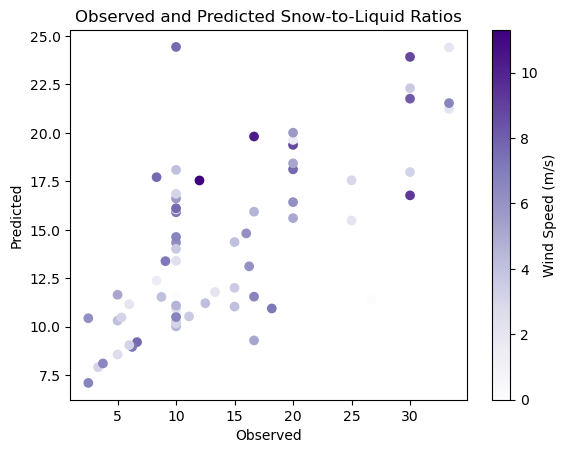

In [82]:
# create a scatter plot of the predicted and observed slr
plt.scatter(ytest, ybest, c=Xtest['wind_speed'], cmap='Purples', marker='o')

# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed and Predicted Snow-to-Liquid Ratios')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Wind Speed (m/s)')

# Display the plot
plt.show()

There doesn't seem to be too much of a correlation here though a few of the darker colored markers are toward the top right of the graph. This may indicate some stronger wind speeds and some undercatch that might be taking place for the precipitation being recorded. This would lead to higher SLRs.

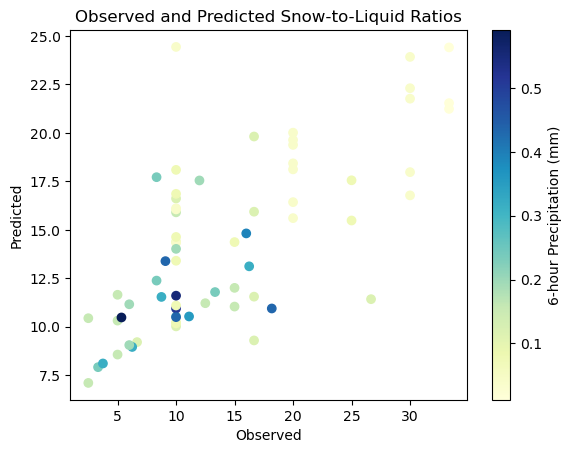

: 

In [83]:
# create a scatter plot of the predicted and observed slr
plt.scatter(ytest, ybest, c=Xtest['precipitation_6_hour'], cmap='YlGnBu', marker='o')

# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed and Predicted Snow-to-Liquid Ratios')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('6-hour Precipitation (mm)')

# Display the plot
plt.show()

Notice how the lighter colored markers are in the top right of the graph. This is suggests the undercatch problem is still playing a role here in our dataset. In turn, the model may be overfitted to those data points as the overpredicted SLRs also mostly have lower 6-hourly precipitation values (especially for the observed 10:1 ratios).  

### Part 4: XAI Techniques

<Axes: >

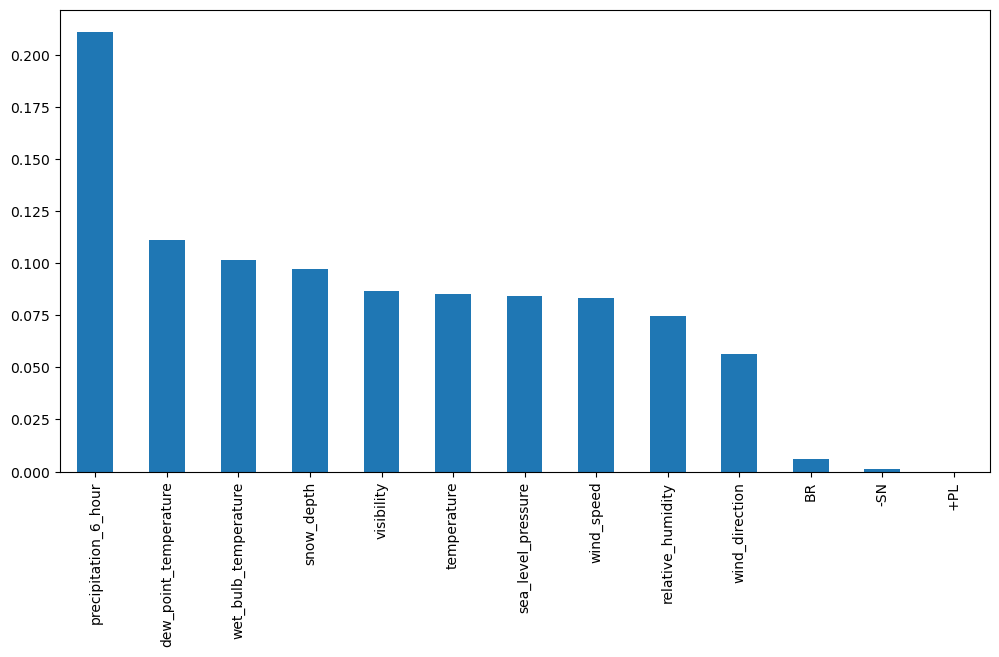

In [69]:
# plot the feature importances of the random forest regressor
importances = pd.Series(best_model.feature_importances_)
importances.index = X.columns
importances.sort_values(inplace=True, ascending=False)
importances.plot.bar(figsize=(12,6))

As expected, based on the clear signal from the previous plots, the 6-hourly precipitation has the largest feature importance. Interestingly, dewpoint and wet bulb temperature are slightly ahead of snow depth here. The present weather conditions here are much lower likely due to the lack of data. But overall, besides precipitation, there isn't much variablility between the feature importance of the other weather variables (because of their correlations with eachother).

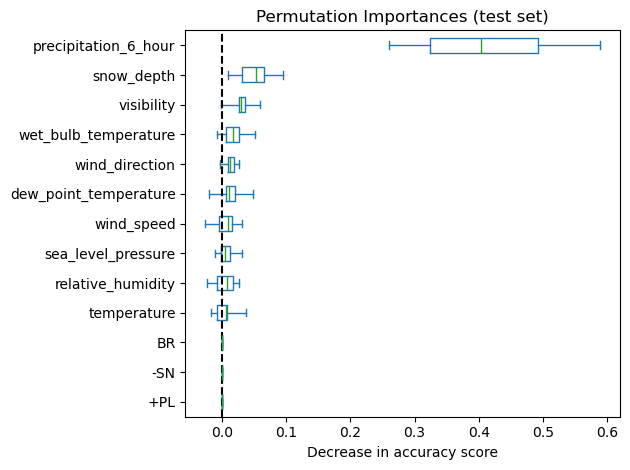

In [70]:
# plot the permutation importances of the model
result = permutation_importance(
    best_model, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Again, we see the importance of the 6-hourly precipitation here. This time, snow depth is next highest (which one would expect both precipitation and snow depth to have a large impact on SLRs calculated).

In [44]:
import shap
shap.initjs()

In [71]:
# get SHAP values for our model
explainer = shap.Explainer(best_model)
shap_test = explainer(Xtest)
shap_values = explainer.shap_values(X)

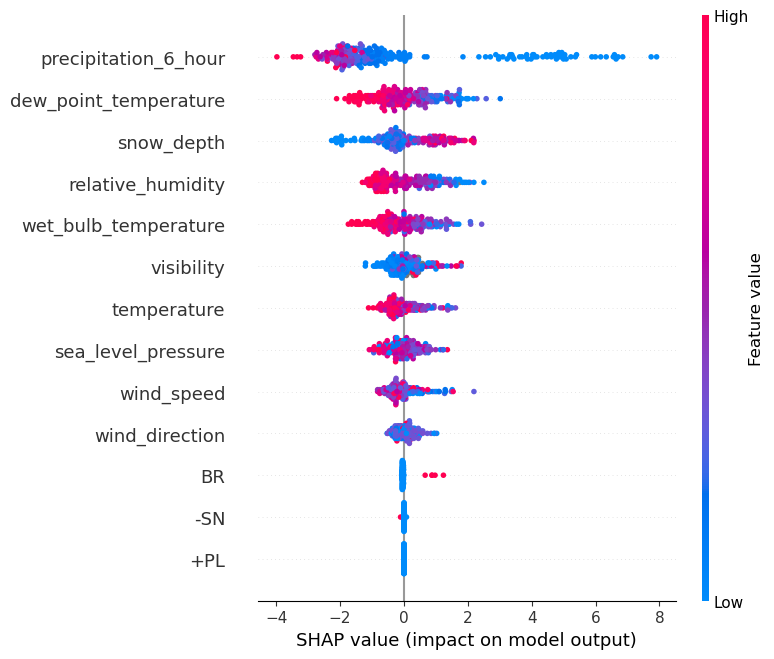

In [72]:
# plot the SHAP summary plot
shap.summary_plot(shap_values, X)

Using SHAP analysis, we can see verify our initial thoughts about low precipitation measurements contributing to the very high SLRs. Dewpoint temperature is the second highest with the lower dewpoints corresponding to higher predicted SLRs. The low dewpoints could represent a drier snow that has a higher SLR. Snow depth is next with higher snow depths generally resulting in larger SLRs. Since we are using a snow depth and not a snow accumulation value, this makes sense. Likely the wetter snow (which has a low SLR) was either melting or compacting. So the 6-hour snow depth measurements might have been lower than an accumulation measurement.

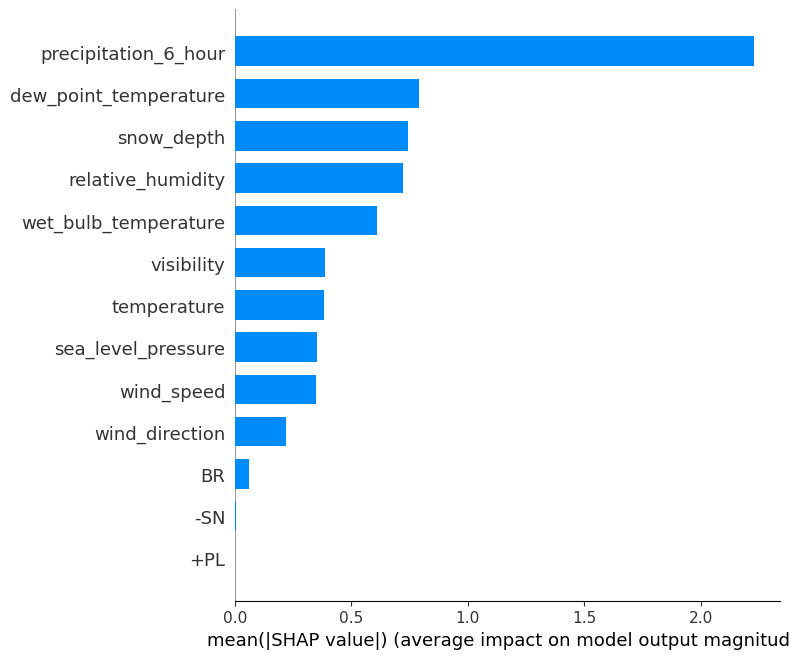

In [73]:
# plot the SHAP summary plot as a bar chart
shap.summary_plot(shap_values, features=X.columns, plot_type='bar')

***

### Final Thoughts and Future Work

Overall, this project demonstrated the importance of having a large amount of data to feed into a random forest model. Since we were only able to get just over 200 data points, the model wasn't able to have a large enough dataset to train off of and predict more accurate results. Also, the inherent challenges in collecting precipitation during the wintertime became a factor here. Undercatch is a notorious issue with ASOS precipitation gauges and led to unrealistically high SLRs being calculated as 'observed' values. Lastly, it would have been more ideal to use a snow accumulation here. Issues like settling and melting can become a factor. Having to rely on a 6-hour snow depth measurement also significantly reduced the amount of data available.

This random forest model was successful in clearly explaining the feature importance of the low 6-hourly precipitation measurement suggesting that overcatch was likely the largest contributer to the poor results. The model had to predict unrealistically high SLRs which reduced its accuracy.

In the future, it would be nice to incorportate snowfall accumulation data instead. Also, it would be interesting to use data from the [CoCoRaHS Network](https://www.cocorahs.org/) on an event by event basis and see if the SLRs reported throughout an event would lead to better predictions given that is calculated from melting the snow rather than catching the snow as it is falling and then melting and measuring (like an ASOS stations). Lastly, expanding this analysis to more than one location would ensure a larger dataset, though still largely confined to New York State to limit geographical differences.